# 📊 Evolution Data Analysis

**Exploratory Data Analysis of Emergent Boids Ecosystem**

Philosophy: Everything is information processing. Simple rules compose. Emergence is reliable.

---

## Contents
1. Setup & Data Loading
2. Dataset Overview
3. Population Dynamics
4. Energy Analysis  
5. Birth & Death Patterns
6. Death Causes Breakdown
7. Stability Metrics
8. Predator-Prey Dynamics
9. Summary & Insights

## 1. Setup & Data Loading

In [18]:
# Import libraries
import sys
from pathlib import Path

# Add parent directory to path so we can import from src
sys.path.insert(0, str(Path.cwd().parent.parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import our ML modules
from src.ml import (
    load_evolution_csv, detect_species_from_columns,
    partition_species_by_role, extract_death_causes, summarize_dataset,
    calculate_birth_rate, calculate_death_rate, calculate_growth_rate,
    calculate_rolling_cv, calculate_species_dominance,
    calculate_ecosystem_stability, calculate_biodiversity_index,
    classify_population_dynamics, generate_stability_report
)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Setup complete!")

✅ Setup complete!


In [19]:
# Load evolution data
df = load_evolution_csv('../../datasets/evolution.csv')
species = detect_species_from_columns(df)
by_role = partition_species_by_role(species)

print(f"✅ Loaded {len(df)} snapshots")
print(f"✅ Species: {', '.join(species)}")
print(f"✅ Prey: {', '.join(by_role['prey'])}")
print(f"✅ Predators: {', '.join(by_role['predator'])}")

✅ Loaded 438 snapshots
✅ Species: cautious, explorer, independent, predator, social
✅ Prey: cautious, explorer, independent, social
✅ Predators: predator


## 2. Dataset Overview

In [20]:
# Dataset summary
summary = summarize_dataset(df, species)

print("📊 Dataset Summary")
print("=" * 50)
print(f"Total Snapshots: {summary['total_snapshots']:,}")
print(f"Tick Range: {summary['tick_range'][0]:,} → {summary['tick_range'][1]:,}")
print(f"Duration: {summary['duration_seconds']:.1f} seconds ({summary['duration_seconds']/60:.1f} minutes)")
print(f"Species Count: {summary['species_count']}")
print(f"Total Births: {summary['total_births']:,}")
print(f"Total Deaths: {summary['total_deaths']:,}")
print(f"Net Growth: {summary['total_births'] - summary['total_deaths']:,}")

# Show first few rows
print("\n📋 First 5 Snapshots:")
df[['tick', 'timestamp'] + [f'{sp}_population' for sp in species]].head(10)

📊 Dataset Summary
Total Snapshots: 438
Tick Range: 3 → 1,314
Duration: 1337.1 seconds (22.3 minutes)
Species Count: 5
Total Births: 14,729
Total Deaths: 11,381
Net Growth: 3,348

📋 First 5 Snapshots:


,tick,timestamp,cautious_population,explorer_population,independent_population,predator_population,social_population
0,3,1766458669098,26,29,38,11,34
1,6,1766458672106,25,30,56,12,38
2,9,1766458675112,26,36,56,13,39
3,12,1766458678118,30,50,71,13,44
4,15,1766458681130,32,54,71,13,47
5,18,1766458684146,32,62,99,13,50
6,21,1766458687153,38,63,100,13,56
7,24,1766458690169,42,80,98,14,62
8,27,1766458693186,42,94,100,14,72
9,30,1766458696203,55,108,98,15,77


## 3. Population Dynamics

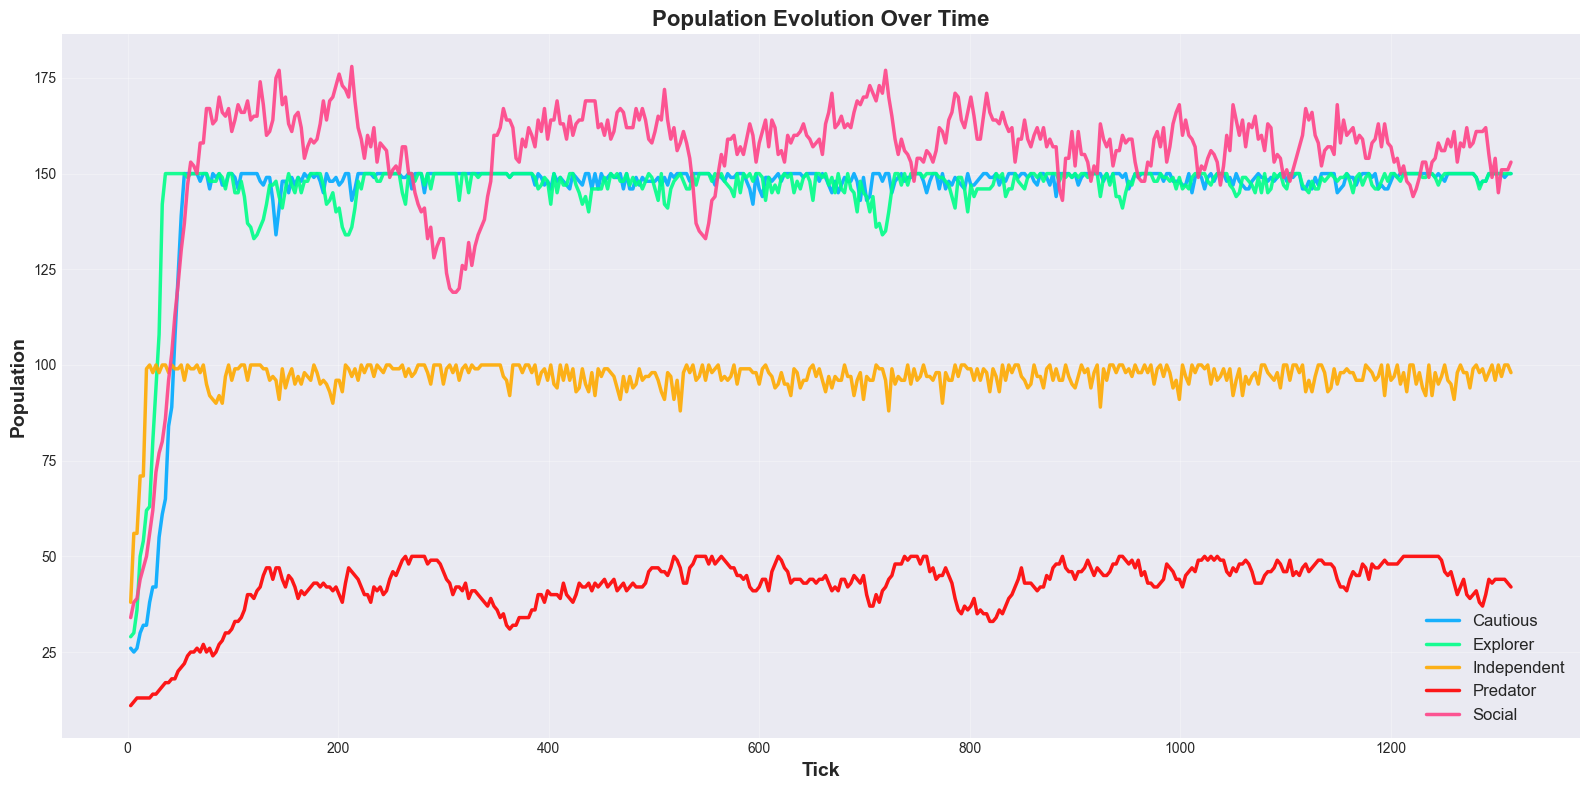


📊 Population Statistics:

Cautious:
  Mean: 145.3
  Min: 25
  Max: 150
  Final: 150

Explorer:
  Mean: 145.7
  Min: 29
  Max: 150
  Final: 150

Independent:
  Mean: 96.9
  Min: 38
  Max: 100
  Final: 98

Predator:
  Mean: 42.2
  Min: 11
  Max: 50
  Final: 42

Social:
  Mean: 154.4
  Min: 34
  Max: 178
  Final: 153


In [21]:
# Plot population trends
fig, ax = plt.subplots(figsize=(16, 8))

colors = {
    'cautious': '#00aaff', 'explorer': '#00ff88', 'independent': '#ffaa00',
    'predator': '#ff0000', 'social': '#ff4488',
}

for sp in species:
    pop_col = f'{sp}_population'
    ax.plot(df['tick'], df[pop_col], label=sp.capitalize(), 
           color=colors.get(sp, None), linewidth=2.5, alpha=0.9)

ax.set_xlabel('Tick', fontsize=14, fontweight='bold')
ax.set_ylabel('Population', fontsize=14, fontweight='bold')
ax.set_title('Population Evolution Over Time', fontsize=16, fontweight='bold')
ax.legend(loc='best', framealpha=0.9, fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Population statistics
print("\n📊 Population Statistics:")
for sp in species:
    pop_col = f'{sp}_population'
    print(f"\n{sp.capitalize()}:")
    print(f"  Mean: {df[pop_col].mean():.1f}")
    print(f"  Min: {df[pop_col].min()}")
    print(f"  Max: {df[pop_col].max()}")
    print(f"  Final: {df[pop_col].iloc[-1]}")

## 4. Energy Analysis

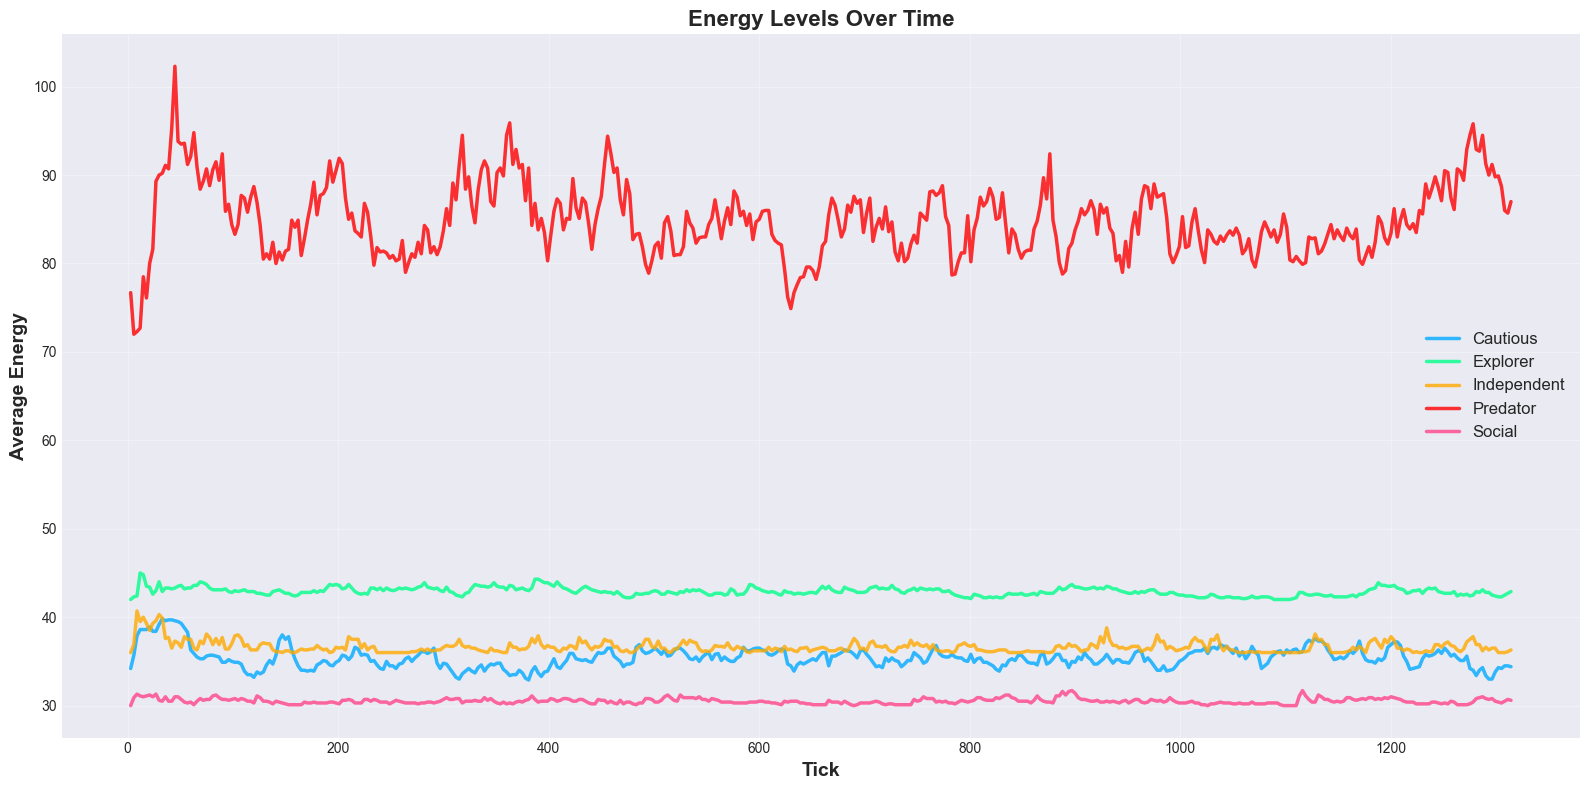

In [22]:
# Plot energy trends
fig, ax = plt.subplots(figsize=(16, 8))

for sp in species:
    energy_col = f'{sp}_energy_mean'
    if energy_col in df.columns:
        ax.plot(df['tick'], df[energy_col], label=sp.capitalize(),
               color=colors.get(sp, None), linewidth=2.5, alpha=0.8)

ax.set_xlabel('Tick', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Energy', fontsize=14, fontweight='bold')
ax.set_title('Energy Levels Over Time', fontsize=16, fontweight='bold')
ax.legend(loc='best', framealpha=0.9, fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Birth & Death Patterns

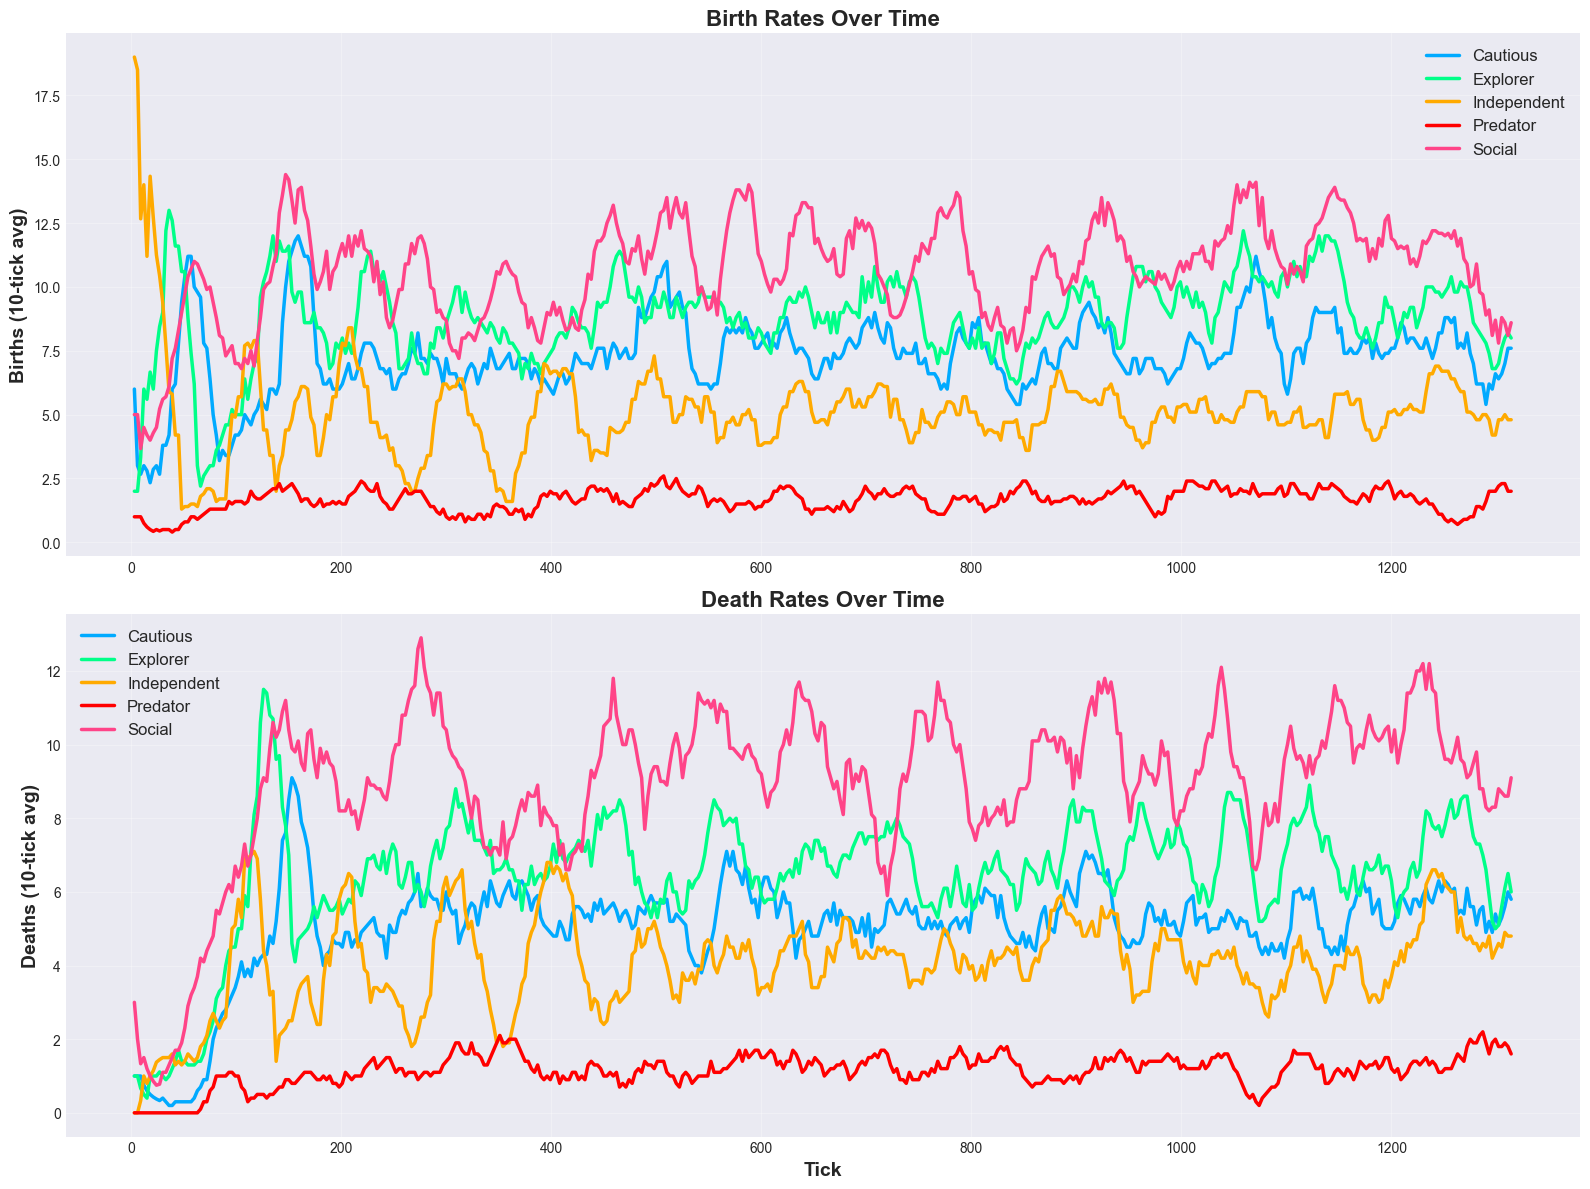

In [23]:
# Plot births and deaths
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

window = 10  # Rolling average

# Births
for sp in species:
    birth_col = f'{sp}_births'
    if birth_col in df.columns:
        rolling = df[birth_col].rolling(window, min_periods=1).mean()
        ax1.plot(df['tick'], rolling, label=sp.capitalize(),
                color=colors.get(sp, None), linewidth=2.5)

ax1.set_ylabel(f'Births ({window}-tick avg)', fontsize=14, fontweight='bold')
ax1.set_title('Birth Rates Over Time', fontsize=16, fontweight='bold')
ax1.legend(loc='best', framealpha=0.9, fontsize=12)
ax1.grid(True, alpha=0.3)

# Deaths
for sp in species:
    death_col = f'{sp}_deaths'
    if death_col in df.columns:
        rolling = df[death_col].rolling(window, min_periods=1).mean()
        ax2.plot(df['tick'], rolling, label=sp.capitalize(),
                color=colors.get(sp, None), linewidth=2.5)

ax2.set_xlabel('Tick', fontsize=14, fontweight='bold')
ax2.set_ylabel(f'Deaths ({window}-tick avg)', fontsize=14, fontweight='bold')
ax2.set_title('Death Rates Over Time', fontsize=16, fontweight='bold')
ax2.legend(loc='best', framealpha=0.9, fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Death Causes Breakdown

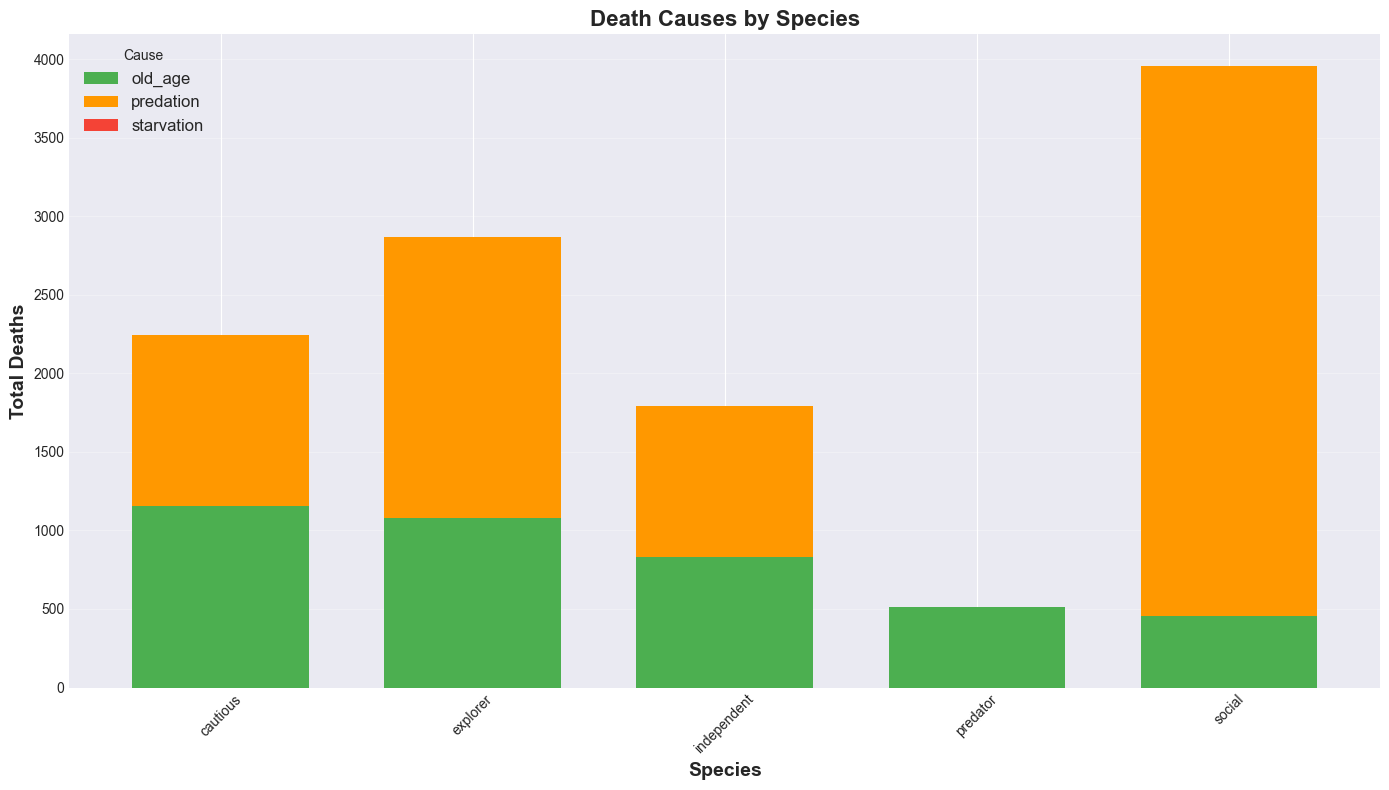


💀 Death Causes Breakdown:

Cautious:
  old_age       1,158
  predation     1,087

Explorer:
  old_age       1,079
  predation     1,791

Independent:
  old_age         831
  predation       960

Predator:
  old_age         515

Social:
  old_age         455
  predation     3,505


In [24]:
# Extract and visualize death causes
death_causes_df = extract_death_causes(df, species)

# Pivot for stacked bar chart
pivot = death_causes_df.pivot(index='species', columns='cause', values='count').fillna(0)

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(14, 8))
pivot.plot(kind='bar', stacked=True, ax=ax, 
          color=['#4CAF50', '#FF9800', '#F44336'], width=0.7)

ax.set_xlabel('Species', fontsize=14, fontweight='bold')
ax.set_ylabel('Total Deaths', fontsize=14, fontweight='bold')
ax.set_title('Death Causes by Species', fontsize=16, fontweight='bold')
ax.legend(title='Cause', framealpha=0.9, fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print breakdown
print("\n💀 Death Causes Breakdown:")
for sp in species:
    sp_deaths = death_causes_df[death_causes_df['species'] == sp]
    if len(sp_deaths) > 0:
        print(f"\n{sp.capitalize()}:")
        for _, row in sp_deaths.iterrows():
            if row['count'] > 0:
                print(f"  {row['cause']:12} {int(row['count']):6,}")

## 7. Stability Metrics

In [26]:
# Generate comprehensive stability report
report = generate_stability_report(df, species)

print("🎯 Stability Analysis")
print("=" * 50)
print(f"\nEcosystem Stability (CV): {report['ecosystem_stability']:.4f}")
print(f"Biodiversity Index: {report['biodiversity']['mean']:.4f}")

print("\n📊 Per-Species Stability:")
for sp in species:
    cv = report['species_stability'][sp]
    dynamics = report['species_dynamics'][sp]
    print(f"  {sp.capitalize():15} CV={cv:.4f} ({dynamics})")

print("\n⚖️  Equilibrium:")
if report['equilibrium']['reached']:
    print(f"  ✅ Reached at tick {report['equilibrium']['tick']:,}")
else:
    print(f"  ⚠️  Not yet reached")

🎯 Stability Analysis

Ecosystem Stability (CV): 0.1018
Biodiversity Index: 1.5283

📊 Per-Species Stability:
  Cautious        CV=0.0988 (oscillating)
  Explorer        CV=0.0859 (oscillating)
  Independent     CV=0.0559 (oscillating)
  Predator        CV=0.1477 (oscillating)
  Social          CV=0.1205 (oscillating)

⚖️  Equilibrium:
  ✅ Reached at tick 666


## 8. Predator-Prey Dynamics

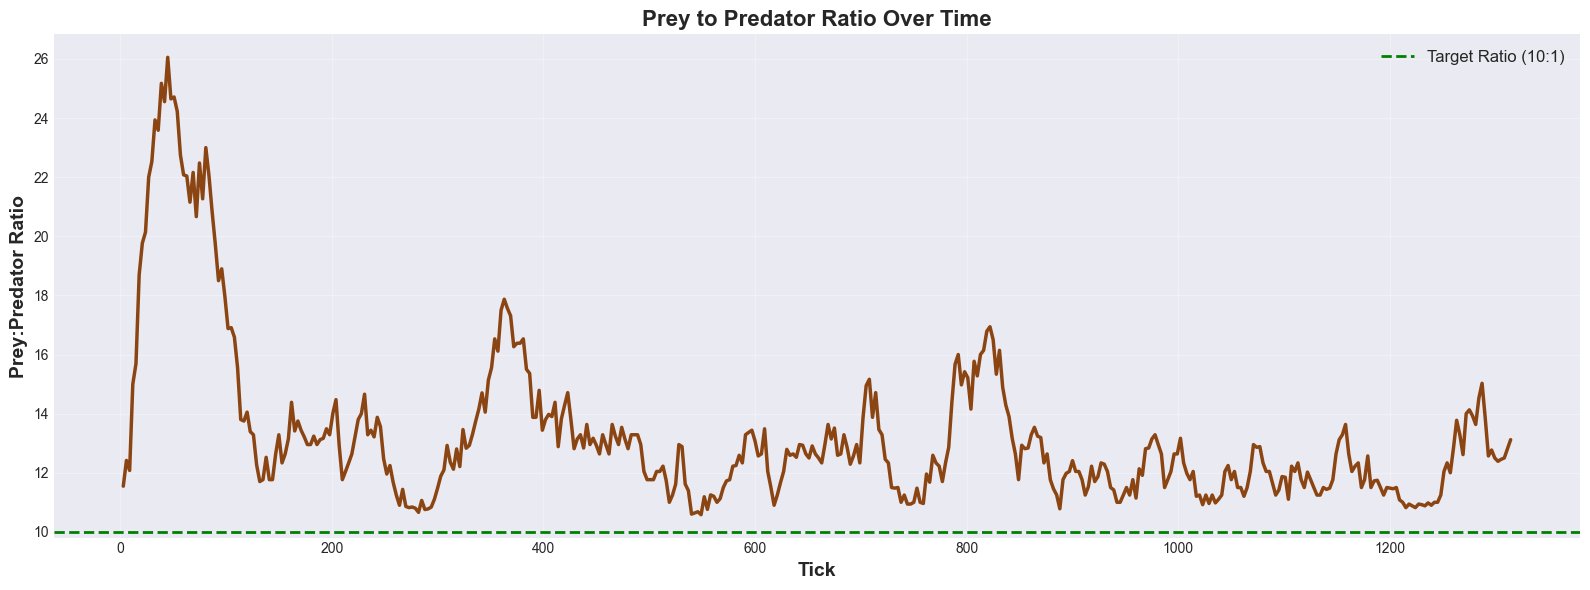


🦌🐺 Predator-Prey Dynamics:
  Mean Ratio: 13.28:1
  Std Dev: 2.73
  Min: 10.58:1
  Max: 26.06:1


In [27]:
# Calculate prey:predator ratio
from feature_engineering import aggregate_species_metric, calculate_prey_predator_ratio

if by_role['prey'] and by_role['predator']:
    prey_total = aggregate_species_metric(df, by_role['prey'], 'population')
    predator_total = aggregate_species_metric(df, by_role['predator'], 'population')
    ratio = calculate_prey_predator_ratio(prey_total, predator_total)
    
    # Plot ratio
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(df['tick'], ratio, color='#8B4513', linewidth=2.5)
    ax.axhline(y=10, color='green', linestyle='--', linewidth=2, 
              label='Target Ratio (10:1)')
    
    ax.set_xlabel('Tick', fontsize=14, fontweight='bold')
    ax.set_ylabel('Prey:Predator Ratio', fontsize=14, fontweight='bold')
    ax.set_title('Prey to Predator Ratio Over Time', fontsize=16, fontweight='bold')
    ax.legend(loc='best', framealpha=0.9, fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n🦌🐺 Predator-Prey Dynamics:")
    print(f"  Mean Ratio: {ratio.mean():.2f}:1")
    print(f"  Std Dev: {ratio.std():.2f}")
    print(f"  Min: {ratio.min():.2f}:1")
    print(f"  Max: {ratio.max():.2f}:1")

## 9. Summary & Insights

In [28]:
print("\n" + "="*70)
print("📊 EVOLUTION ANALYSIS SUMMARY")
print("="*70)

print(f"\n📈 Dataset:")
print(f"  Snapshots: {len(df):,}")
print(f"  Duration: {summary['duration_seconds']/60:.1f} minutes")

print(f"\n🦠 Population:")
print(f"  Total Births: {summary['total_births']:,}")
print(f"  Total Deaths: {summary['total_deaths']:,}")
print(f"  Net Growth: {summary['total_births'] - summary['total_deaths']:,}")

print(f"\n🎯 Stability:")
print(f"  Ecosystem CV: {report['ecosystem_stability']:.4f}")
print(f"  Biodiversity: {report['biodiversity']['mean']:.4f}")

print("\n" + "="*70)
print("✅ Analysis Complete!")
print("="*70)


📊 EVOLUTION ANALYSIS SUMMARY

📈 Dataset:
  Snapshots: 438
  Duration: 22.3 minutes

🦠 Population:
  Total Births: 14,729
  Total Deaths: 11,381
  Net Growth: 3,348

🎯 Stability:
  Ecosystem CV: 0.1018
  Biodiversity: 1.5283

✅ Analysis Complete!
